# Practical RL - [Catch The Rainbow](https://www.youtube.com/watch?v=p3VgV31vmUE)

See all implementations of Rainbow sans distributional RL at [cstorm125/rainbow](https://github.com/cstorm125/rainbow).

## Imports

In [1]:
# #uncomment if you're running from colab
# %tensorflow_version 2.x

%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import deque, Counter
import matplotlib.pyplot as plt
import random
import gym
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tqdm import tqdm_notebook

## RL in The News

Deep reinforcement learning agents have displayed some amazing feats in the media:
* Beating professional [Go players](https://deepmind.com/research/alphago/) and, to some extent, [DotA players](https://youtu.be/UZHTNBMAfAA?t=2m40s).
* Achieve (super) human-level scores in [Atari Games](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)
* Masterfully play [Flappy Bird](https://www.youtube.com/watch?v=hri7ir5qhj0)

![rl-news.png](https://i.postimg.cc/VvRkL4Fm/rl-news.png)

What these tasks usually have in common is that they:
1. Have easy access to training data, usually via simulation and self-supervision
2. Do not require memory (episodic); your current best Go move only depends on the current board state
3. Are game-like: 
    * deterministic; a given state-action pair will always yield the same result
    * fully observable; the agent has all relevant information about its task
    * discrete; fixed timesteps such as a turn for Go and a frame for Flappy Bird
    * known; the rules such as legal actions and rewards are known by the agent
    * static; the rules do not change
    * 1-2 agents; either the agent is optimizing for something alone or competing/cooperating with another agent/human

Read more on environment classification from [Russel and Norvig (2009)](https://en.wikibooks.org/wiki/Artificial_Intelligence/AI_Agents_and_their_Environments).

Image from Andrey Kurenkov's [Reinforcement learning’s foundational flaw](https://thegradient.pub/why-rl-is-flawed/), highly recommended.
<img src="https://i.postimg.cc/XJfCWnRB/venn.png" 
width =500/>

The issue with this is that these are relatively "easy" **parameter search problems** and thus might have more efficient and even more effective results with much simpler methods (Kurenkov, 2018):
1. [Simple random search provides a competitive approach to reinforcement learning](https://arxiv.org/abs/1803.07055)
2. [Deep Neuroevolution: Genetic Algorithms Are a Competitive Alternative for Training Deep Neural Networks for Reinforcement Learning](https://arxiv.org/abs/1712.06567)
3. [Evolution Strategies as a Scalable Alternative to Reinforcement Learning](https://arxiv.org/abs/1703.03864)
4. [Towards Generalization and Simplicity in Continuous Control](https://arxiv.org/abs/1703.02660)

## RL in Real Life

In real-world use cases, deep reinforcement learning (here we do not consider multi-armed bandits, the world's most popular method for ads optimization and cold-start recommendation) has solved the following problems:
1. Neural architecture search for better algorithms aka [AutoML](https://cloud.google.com/automl/)※
2. [Continuous control](https://arxiv.org/abs/1509.02971) in robotics※
3. Reduce data center power usage and [save 40% of electricity bill](https://deepmind.com/blog/deepmind-ai-reduces-google-data-centre-cooling-bill-40/)
4. [Ads bidding](http://wnzhang.net/papers/rlb.pdf), outperforming supervised linear models in research
5. Push notification by Facebook's [Horizon](https://research.fb.com/publications/horizon-facebooks-open-source-applied-reinforcement-learning-platform/), outperforming supervised models by incorporating long-term outlooks of sending a push notificiation.
6. [Winning Texas Hold em' Poker](https://science.sciencemag.org/content/365/6456/885.full); not exactly industry use case but it shows how an RL agent can be successful in a partially observable, multi-agent environment

Some use cases that people seem to be working on but no publicised results:
1. [Algorithmic trading](http://www.wildml.com/2018/02/introduction-to-learning-to-trade-with-reinforcement-learning/)
2. [Traffic control](https://flow.berkeley.edu/)
3. [Cold-start recommendation engine](https://arxiv.org/abs/1801.05532)

※ Problems that are closest to AlphaGo and most Atari

![rl-real.png](https://i.postimg.cc/DyKfbtS5/rl-real.png)

A lot of real-world use cases for reinforcement learning happen with the following motivations:
1. Multi-agent and/or dynamic environment; Google even cited the reason for using reinforcement learning to control temperature at data centers as `The system cannot adapt quickly to internal or external changes (like the weather). This is because we cannot come up with rules and heuristics for every operating scenario.`
2. Optimizing for long-term goals; Facebook said in regard to using reinforcement learning for push notifications that `Historically, we have used supervised learning models for predicting click through rate (CTR) and likelihood that the notification leads to meaningful interactions...This however, didn’t capture the long term or incremental value of sending notifications. There can be some signals that appear long after the decision to send or drop is madeor can’t be attributed directly to the notification.`
3. Human-out-of-the-loop training scheme; instead of optimizing for a human-generated metric then rely on human discretion for rule-based policy development, an RL agent can directly optimize for the rewards (which stills need to be engineered by humans). See [Introduction to Learning to Trade with Reinforcement Learning](http://www.wildml.com/2018/02/introduction-to-learning-to-trade-with-reinforcement-learning/) by Denny Britz.
![denny.png](https://i.postimg.cc/G3vbPdTV/denny.png)

Obviously, this breaks a little with the news-worthy use cases, especially with the game-like charactersitic, but they still requires a lot of training data and are memoryless or can be simplified as memory less.


## Gameplan

In order to create a successful (read "better than supervised learning") reinforcement learning project, you might consider the following steps:
1. Does your use case need reinforcement learning? Can it be formulated as a reinforcement learning problem?
2. Set up an environment; define state, action, reward, timestep, and what it means to solve your environment.
3. Establish baselines with "unintelligent" agents like random, single-action, or rule-based agents.
4. Create your training scheme; define memories (if necessary), networks and agents to use.
5. Test and debug your agent; monitor losses, weights, agent's actions and scores.
    * Test your agent and make sure it can learn with toy environment such as `CartPole-v1`
    * Play a junior version of your environment with your agent; for instance, for single-stock trading, test if an agent knows how to trade a
    stock that always goes up or down.
    * Play the real version until solved
    * Go back to 4. and create a training scheme with better memories, networks, or agents


Here are a few use cases translated into reinforcement learning schemes: 
* Walking robots
    * Environment: sidewalks
    * Agent: a robot
    * States: positions, velocities and accelerations of body parts
    * Actions: move arms, legs, various joints in the body
    * Rewards: fall or not
    * Episodes: seconds, miliseconds until fall
* Ads bidding
    * Environment: Google Adwords
    * Agent: an ecommerce company
    * States: campaign impressions, clicks, purchases
    * Actions: adjust bid prices and budget
    * Rewards: conversion rates, cost of new customer acquisitions
    * Episodes: daily or hourly until campaign ends
* Retail stock trading
    * Environment: the stock market
    * Agent: a retail investor who cannot influence market prices
    * States: market prices, volumes, and other indicators
    * Actions: buy, hold, sell
    * Rewards: returns, returns adjusted by volatility, and so on
    * Episodes: daily, hourly, every second until we are extremely rich or broke
    
**Concept Assigment** Come up with one or more scenarios that you think could be framed as a reinforcement learning problem and list their elements like the example above. Some candidates are:
* [AlphaGo](https://deepmind.com/research/alphago/)
* [OpenAI Five Dota Bots](https://openai.com/five/)
* [Pancake-flipping Robots](https://www.youtube.com/watch?v=W_gxLKSsSIE&list=PL5nBAYUyJTrM48dViibyi68urttMlUv7e)

## Environment

You will create your own environment for a real-world use case as a homework assignment. In order to focus on agent improvement in class, we will be using the most basic environment of OpenAi gym `CartPole-v1`.

The pole-balancing task is described as fololows:
> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [2]:
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/charin/anaconda3/envs/drlnd/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


**Coding Assignment** Find out what are the following elements

* States:
* Actions:
* Rewards: 

In [1]:
'''
Fill in the code
'''

'\nFill in the code\n'

**Conceptual Assignment** 
* Is the reward suitable for our goal of balancing the pole as long as possible? 
* What is the suitable discount factor we should use for this task?

## Unintelligent Benchmarks

Make sure we are not spending time and effort to solve a problem that can be solved with a rule-based model, or worse random play.

### Random Play

In [3]:
'''
Fill in the codes
* Play 1,000 episodes randomly
* Plot the scores and 100-episode moving averages for all timesteps.
* Get distribution of all state variables
'''
env = gym.make('CartPole-v1')


'\nFill in the codes\n* Play 1,000 episodes randomly\n* Plot the scores and 100-episode moving averages for all timesteps.\n* Get distribution of all state variables\n'

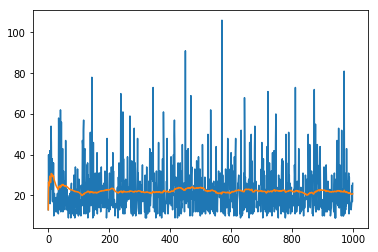

In [5]:
plt.plot(scores)
plt.plot(moving_scores)

In [6]:
state_df = pd.DataFrame(states)
state_df.describe()

,0,1,2,3
count,22149.000000,22149.000000,22149.000000,22149.000000
mean,0.007007,0.013170,0.002109,0.003979
std,0.114448,0.541922,0.092214,0.787439
min,-0.823471,-2.488693,-0.209420,-2.885022
25%,-0.040050,-0.353977,-0.050219,-0.514620
50%,0.001558,0.004689,0.001493,0.004316
75%,0.043626,0.367320,0.056469,0.528946
max,2.201445,2.953536,0.209294,2.718612


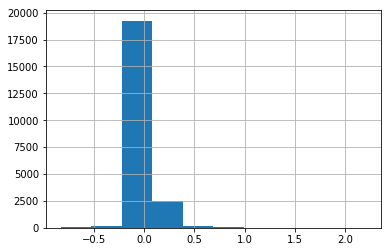

In [7]:
state_df[0].hist()

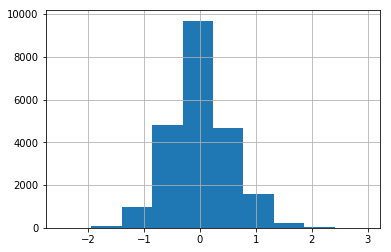

In [8]:
state_df[1].hist()

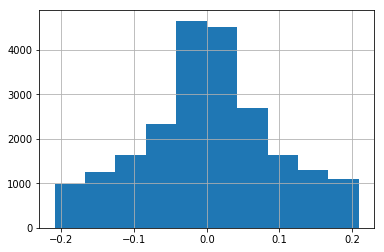

In [9]:
state_df[2].hist()

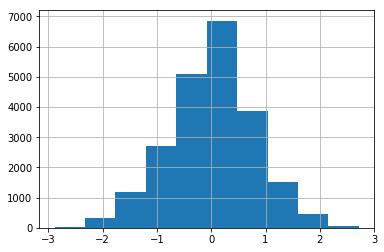

In [10]:
state_df[3].hist()

### Rule-based

In [11]:
'''
Fill in the code
* Play 1,000 episodes with a rule you devised
* Plot the scores and 100-episode moving averages for all timesteps.
    Observation: 
        Type: Box(4)
        Num	Observation                 Min         Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24 deg        24 deg
        3	Pole Velocity At Tip      -Inf            Inf
'''
env = gym.make('CartPole-v1')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Episdoe 99 Moving Average: 40.84848484848485
Episdoe 199 Moving Average: 41.7
Episdoe 299 Moving Average: 42.33
Episdoe 399 Moving Average: 42.4
Episdoe 499 Moving Average: 43.25
Episdoe 599 Moving Average: 44.2
Episdoe 699 Moving Average: 40.47
Episdoe 799 Moving Average: 42.46
Episdoe 899 Moving Average: 42.61
Episdoe 999 Moving Average: 42.99



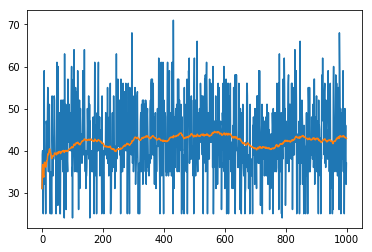

In [12]:
plt.plot(scores)
plt.plot(moving_scores)

## From Research to Implementation

The main objective of this course is for you to be able to implement reinforcement learning algorithms from research papers on your own. In this class, you will implement six out of seven improvements of Q-learning proposed in the [Rainbow paper](https://arxiv.org/pdf/1710.02298.pdf). One of the most important tricks in doing this is to
1. Understand the motivation behind improvements; most papers propose a few improvements to current algorithms. Finding out what problems they are trying to solve will help us implement (or not implement them if they are not useful for our problems) them more easily.
2. Find and convert the pseudo-codes into a code snippet of your language of choice; Greek letters and equations can be daunting but excecuting them in codes can be deceptively easy.

## Vanilla DQN

DeepMind's [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) introduces the framework of deep Q-learning which arguably started the recent interests in reinforcement learning as a whole. The framework is based on Q-learning, which is as follows:
![Q_learning](https://github.com/Datatouille/rl-workshop/raw/master/img/qlearning.png)
Deep Q-learning differs from a function-approximated Q-learning in that it proposed two improvements.
![DQN](https://github.com/Datatouille/rl-workshop/raw/master/img/dqn.png)
**Conceptual Assignment** Skim the paper and find out what these improvements and their motivations are.
1. Replay memory: this is done so that past transitions can be reused and also in a manner that avoid correlations between samples.
2. Local and target networks: this is done so that the agent is not approximating the Q-function (local network) based on its own estimate but rather an earlier version of it (target network)

### Replay Memory

**Coding Assignment** Create a replay memory class with methods
* `add(self,*args)` to add a `(state,action,reward,next_state,done)` tuple or dictionary to the memory.
* `sample(self,batch_size)` to sample a batch of `(state,action,reward,next_state,done)` where each element is a tensor of `(batch_size,dimension)` dimensions.

In [13]:
'''
Fill in the codes
'''
class VanillaMemory:
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.memory = deque(maxlen=memory_size) 
    def add(self, *args):
        pass
    def sample(self, batch_size):
        pass
    def __len__(self):
        return len(self.memory)

In [14]:
mem = VanillaMemory(100)
env = gym.make('CartPole-v1')

scores = []
scores_deque = deque(maxlen=100) 
moving_scores = []
states=[]

for i in tqdm_notebook(range(1000)):
    #one episode
    state = env.reset()
    score = 0
    while True:
        states.append(state)
        action = np.random.choice(range(env.action_space.n))
        next_state, reward, done, info = env.step(action)
        mem.add(state,action,reward,next_state,done)
        score+=reward
        state = next_state
        if done: break
    #book keeping
    scores.append(score)
    scores_deque.append(score)
    moving_scores.append(np.mean(scores_deque))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [15]:
len(mem), mem.sample(3)

(100, (<tf.Tensor: id=1, shape=(3, 4), dtype=float32, numpy=
  array([[-0.02183087,  0.01245179, -0.02250284,  0.04014244],
         [-0.00628558, -0.4152354 ,  0.02869763,  0.5840236 ],
         [-0.12325238, -1.3975149 ,  0.20568569,  2.2322502 ]],
        dtype=float32)>, <tf.Tensor: id=3, shape=(3, 1), dtype=int32, numpy=
  array([[1],
         [0],
         [0]], dtype=int32)>, <tf.Tensor: id=5, shape=(3, 1), dtype=float32, numpy=
  array([[1.],
         [1.],
         [1.]], dtype=float32)>, <tf.Tensor: id=7, shape=(3, 4), dtype=float32, numpy=
  array([[-0.02158183,  0.20788908, -0.02169999, -0.25955456],
         [-0.01459029, -0.6107474 ,  0.0403781 ,  0.8856067 ],
         [-0.15120268, -1.5939119 ,  0.2503307 ,  2.580682  ]],
        dtype=float32)>, <tf.Tensor: id=9, shape=(3, 1), dtype=float32, numpy=
  array([[0.],
         [0.],
         [1.]], dtype=float32)>))

### Networks

**Coding Assigment** Create a network class similar to the one used for function approximation.

In [16]:
'''
Fill in the codes for your Q-network
'''
class DenseNetwork(models.Model):
    def __init__(self, output_size, hidden_sizes, **args):
        super(DenseNetwork, self).__init__()
        pass
    def call(self, x, training=True):
        pass

In [17]:
m = DenseNetwork(env.action_space.n, [16])
m(state[None,:])

<tf.Tensor: id=69, shape=(1, 2), dtype=float64, numpy=array([[-0.70297619, -0.10077457]])>

### Agent

**Coding Assignment** Fill in the methods `learn` and `act` in the agent below (also `get_eps` to get epsilon-greedy). Notice how they are different from the function approximation version.

In [18]:
class DQNAgent:
    def __init__(self, state_size, action_size, replay_memory,
        lr=1e-3, bs = 64, clip=1., hidden_sizes = [256,256],
        gamma=0.99, tau= 1e-3, update_interval = 5, update_times = 1,
        Architecture=DenseNetwork):
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_sizes = hidden_sizes
        self.lr = lr
        self.bs = bs
        self.gamma = gamma
        self.update_interval = update_interval
        self.update_times = update_times
        self.tau = tau
        self.losses = []
        self.clip = clip
        self.Architecture = Architecture

        #networks
        self.network_local = Architecture(output_size=self.action_size, hidden_sizes = self.hidden_sizes, 
            input_size=state_size)
        self.network_local.build(input_shape=(None,self.state_size))
        self.network_target = Architecture(output_size=self.action_size,hidden_sizes=self.hidden_sizes,
            input_size=state_size)
        self.network_target.build(input_shape=(None,self.state_size))
        #make the target network exactly same as the local network
        self.network_target.set_weights(self.network_local.get_weights())
        
        #optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, clipvalue=self.clip)
        
        # replay memory
        self.memory = replay_memory
        # count time steps and episodes
        self.t_step = 0
        self.episodes = 0
    
    def step(self, state, action, reward, next_state, done):
        #add transition to replay memory
        self.memory.add(state, action, reward, next_state, done, #for all others
            self.episodes, self.t_step) #for nstep memory

        #increment episodes if done
        if done: 
            self.t_step = 0
            self.episodes+=1
        
        #update target network
        self.soft_update()
        #self.hard_update()
        
        # learn every self.t_step
        self.t_step += 1
        if self.t_step % self.update_interval == 0:
            if len(self.memory) > self.bs:
                for _ in range(self.update_times):
                    transitions = self.memory.sample(self.bs)
                    loss = self.learn(transitions)
                    self.losses.append(loss)

    def act(self, state):
        '''
        Fill in the codes
        '''
        pass

    #we use tf.function decorator for training process to switch from eager to static graph
    #NOT compatible with PrioritizedMemory yet
    #with decorator
    #1.64 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    #without decorator
    #2.93 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
#     @tf.function
    def learn(self, transitions):
        '''
        Fill in the codes
        '''
        states, actions, rewards, next_states, dones = transitions
        #calculate q_targets
        #calculate q_expected from local network
        #return the loss
        pass
    
    def vanilla_loss(self, q_targets, q_expected):
        '''
        Fill in the codes
        '''
        #implement MSE loss
        pass

    def hard_update(self):
        if self.t_step % 1/self.tau==0:
            self.network_target.set_weights(self.network_local.get_weights())

    def soft_update(self):
        weights_local = np.array(self.network_local.get_weights())
        weights_target = np.array(self.network_target.get_weights())
        self.network_target.set_weights(self.tau * weights_local + (1 - self.tau) * weights_target)
        
    def get_eps(self, i, eps_start = 1., eps_end = 0.001, eps_decay = 0.9):
        '''
        Fill in the codes
        '''
        pass

### Training

Let's use the agent we built to solve `CartPole-v1`. The official solve score is 200 over 100 episodes, but for the sake of time we will use 100. For fully solved versions, see the notebooks in the repository.

In [19]:
env = gym.make('CartPole-v1')
mem = VanillaMemory(int(1e5)) 
a = DQNAgent(state_size = env.reset().shape[0], hidden_sizes = [256,256],
             action_size = env.action_space.n, replay_memory = mem) 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [20]:
def run_agent(env,a):
    scores = []
    scores_deque = deque(maxlen=100) 
    moving_scores = []
    start_time = datetime.now()
    solved_score=100
    action_df = []
    weight_df = []

    for i in tqdm_notebook(range(10000)):
        if (i+1) % 100==0: print(f'Episdoe {i} Moving Average: {np.mean(scores_deque)}')
        state = env.reset()
        score = 0
        t=0
        actions = []
        while True:
            t+=1
            #select action
            action = a.act(state)  
            actions.append(action)

            #env step
            next_state, reward, done, info = env.step(action)   

            #engineer the reward to motivate your agent even more
            if done: 
                fake_reward = reward
            else:
                fake_reward = reward

            #agent step
            a.step(state,action,fake_reward,next_state,done)

            #collect score
            score += reward

            #go to next state
            state = next_state   

            #break if done
            if done: break

        #book keeping
        scores.append(score)
        scores_deque.append(score)
        moving_scores.append(np.mean(scores_deque))
        action_df.append(Counter(actions))
        weight_df.append([tf.reduce_mean(i).numpy() for i in a.network_local.get_weights()])

        if moving_scores[-1] > solved_score: 
            print(f'Solved at Play {i}: {datetime.now() - start_time} Moving average: {moving_scores[-1]}')
            break
    return scores, moving_scores, a.losses, action_df, weight_df

In [21]:
scores, moving_scores, losses, action_df, weight_df = run_agent(env,a)

Episdoe 99 Moving Average: 10.252525252525253
Episdoe 199 Moving Average: 9.46
Episdoe 299 Moving Average: 9.52
Episdoe 399 Moving Average: 9.37
Episdoe 499 Moving Average: 9.4
Episdoe 599 Moving Average: 96.4
Solved at Play 600: 0:01:03.015558 Moving average: 101.17


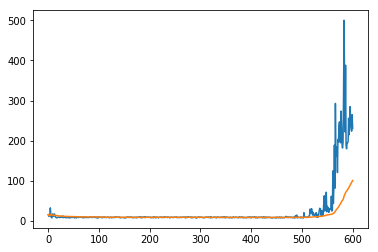

In [22]:
#score plot
plt.plot(scores)
plt.plot(moving_scores)

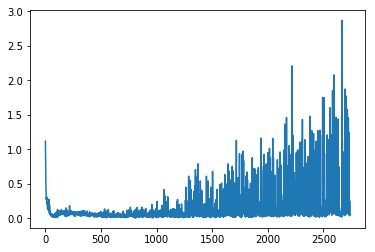

In [23]:
#loss of local network
plt.plot(losses)

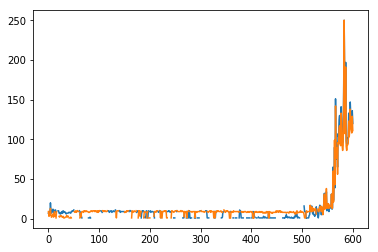

In [24]:
#number of actions per episode
action_df = pd.DataFrame(action_df)
for i in action_df.columns:
    plt.plot(action_df[i])

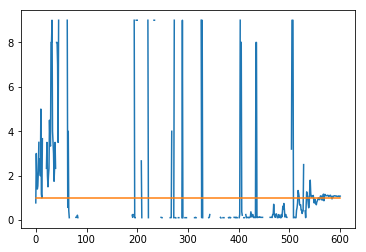

In [25]:
#ratio of actions
plt.plot(action_df[0]/action_df[1])
plt.plot([1 for i in range(action_df.shape[0])])

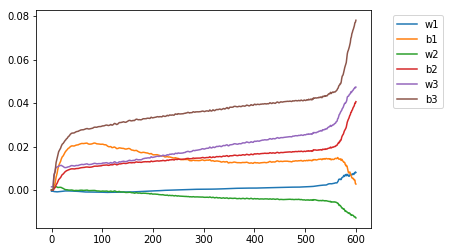

In [26]:
#average weight of each layer
weight_df = pd.DataFrame(weight_df)
weight_df.columns = [str(i.shape) for i in a.network_local.get_weights()]
weight_df.columns = ['w1','b1','w2','b2','w3','b3']
for i in range(weight_df.shape[1]):
    plt.plot(weight_df.iloc[:,i])
plt.legend(bbox_to_anchor=(1.05,1),loc=2)

## [Double Deep Q-learning](https://arxiv.org/pdf/1509.06461.pdf)

**Coding Assignment** What is the motivation for DDQN? Can you prove that it is really the case?

In [27]:
'''
Fill in the codes
'''

(20, 100, 15, 17)

**Coding Assigment** Make our agent DDQN. 

*Hint* Find the pseudocode in the [paper](https://arxiv.org/pdf/1509.06461.pdf)

In [28]:
class DQNAgent:
    def __init__(self, state_size, action_size, replay_memory,
        lr=1e-3, bs = 64, clip=1., hidden_sizes = [256,256],
        gamma=0.99, tau= 1e-3, update_interval = 5, update_times = 1,
        Architecture=DenseNetwork, double=True):
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_sizes = hidden_sizes
        self.lr = lr
        self.bs = bs
        self.gamma = gamma
        self.update_interval = update_interval
        self.update_times = update_times
        self.tau = tau
        self.losses = []
        self.clip = clip
        self.Architecture = Architecture
        self.double = double

        #networks
        self.network_local = Architecture(output_size=self.action_size, hidden_sizes = self.hidden_sizes, 
            input_size=state_size)
        self.network_local.build(input_shape=(None,self.state_size))
        self.network_target = Architecture(output_size=self.action_size,hidden_sizes=self.hidden_sizes,
            input_size=state_size)
        self.network_target.build(input_shape=(None,self.state_size))
        #make the target network exactly same as the local network
        self.network_target.set_weights(self.network_local.get_weights())
        
        #optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, clipvalue=self.clip)
        
        # replay memory
        self.memory = replay_memory
        # count time steps and episodes
        self.t_step = 0
        self.episodes = 0
    
    def step(self, state, action, reward, next_state, done):
        #add transition to replay memory
        self.memory.add(state, action, reward, next_state, done, #for all others
            self.episodes, self.t_step) #for nstep memory

        #increment episodes if done
        if done: 
            self.t_step = 0
            self.episodes+=1
        
        #update target network
        self.soft_update()
        #self.hard_update()
        
        # learn every self.t_step
        self.t_step += 1
        if self.t_step % self.update_interval == 0:
            if len(self.memory) > self.bs:
                for _ in range(self.update_times):
                    transitions = self.memory.sample(self.bs)
                    loss = self.learn(transitions)
                    self.losses.append(loss)

    def act(self, state):
        eps = self.get_eps(self.episodes)
        action_values = self.network_local(tf.cast(state[None,:],dtype=tf.float32))
        #epsilon greedy exploration
        if random.random() > eps:
            return np.argmax(action_values.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    #we use tf.function decorator for training process to switch from eager to static graph
    #NOT compatible with PrioritizedMemory yet
    #with decorator
    #1.64 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    #without decorator
    #2.93 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
#     @tf.function
    def learn(self, transitions):
        states, actions, rewards, next_states, dones = transitions
        '''
        Fill in the codes
        '''
        #Make DDQN here
            
        #bellman
        q_targets = rewards + (self.gamma * q_targets_next) * (1 - dones)
        q_targets = q_targets[:,0] #flatten q_targets

        with tf.GradientTape() as tape:
            #get predictions of all actions
            preds = self.network_local(states)
            
            #get index of actions used to calculate q_expected
            actions = actions[:,0] #flatten actions
            seq = tf.range(0, actions.shape[0])
            action_idxs = tf.transpose(tf.stack([seq, actions]))

            #get q values only at specific action indice
            #tensorflow has this weird way to gather where you need to put index as
            #[[0, action_idx1],[1, action_idx2],...,[n, action_idxn]]
            q_expected = tf.gather_nd(preds, action_idxs)
            
            #calculate loss
            loss = self.vanilla_loss(q_targets, q_expected)
            
            #get gradients
            gradients = tape.gradient(loss, self.network_local.trainable_weights)
        
        #apply gradients
        self.optimizer.apply_gradients(zip(gradients,self.network_local.trainable_weights))
        
        return loss

    def vanilla_loss(self, q_targets, q_expected):
        return tf.keras.losses.mse(q_targets, q_expected)

    def hard_update(self):
        if self.t_step % 1/self.tau==0:
            self.network_target.set_weights(self.network_local.get_weights())

    def soft_update(self):
        weights_local = np.array(self.network_local.get_weights())
        weights_target = np.array(self.network_target.get_weights())
        self.network_target.set_weights(self.tau * weights_local + (1 - self.tau) * weights_target)
        
    def get_eps(self, i, eps_start = 1., eps_end = 0.001, eps_decay = 0.9):
        eps = max(eps_start * (eps_decay ** i), eps_end)
        return(eps)

In [29]:
env = gym.make('CartPole-v1')
mem = VanillaMemory(int(1e5)) 
a = DQNAgent(state_size = env.reset().shape[0], hidden_sizes = [256,256],
             action_size = env.action_space.n, replay_memory = mem, double=True) 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [30]:
scores, moving_scores, losses, action_df, weight_df = run_agent(env,a)

Episdoe 99 Moving Average: 11.616161616161616
Episdoe 199 Moving Average: 9.5
Episdoe 299 Moving Average: 9.64
Episdoe 399 Moving Average: 9.6
Solved at Play 494: 0:00:57.970140 Moving average: 100.07


## [Dueling Networks](https://arxiv.org/pdf/1511.06581.pdf)

**Advantage** is the surplus of state-action value compared to the current state value. Intuitively, it is how much better the agent expects the results to be if it took this particular action instead of any action at all. It is formulated as:

$$A(s,a) = Q(s,a) - V(s)$$

However, we cannot estimate any of these values since we need to fix 2 out of 3 values to get a unique solution. The [dueling network paper](https://arxiv.org/pdf/1511.06581.pdf) remedy this by proposing an equation where advantage is zero:

$$Q(s,a) = V(s) + A(s,a) - max_{a'}A(s,a')$$

and for numerical stability:

$$Q(s,a) = V(s) + A(s,a) - \frac{1}{|A|}\sum_{a'}A(s,a')$$


This dueling network architecture essentially has three important parts:

1. Feature extraction stream - a set of dense layers that takes input of state (`batch_size` * `state_size`) and output a number of hidden layers (`batch_size` * `nb_hidden`)
2. Value stream - a set of dense layers that takes input from the feature extraction stream (`batch_size` * `nb_hidden`) and output number of actions (`batch_size` * `action_size`)
3. Advantage stream - a set of dense layers that takes input from the feature extraction stream (`batch_size` * `nb_hidden`) and output a single advantage (`batch_size` * `1`)

We combine the result of 2. and 3. in the following manner:

$$Q(s,a) = V(s) + A(s,a) - \frac{1}{|A|}\sum_{a'}A(s,a')$$

where
* $V(s)$ is the value function given state $s$ 
* $A(s,a)$ is the advantage function given state $s$  and action $a$.

**Coding Assignment** Modify our `DenseNetwork` to be `DuelingNetwork`.

In [31]:
'''
Fill in the codes
'''
class DuelingNetwork(models.Model):
    def __init__(self, output_size, hidden_sizes, **args):
        super(DuelingNetwork, self).__init__()
        pass
    def call(self, x, training=True):
        pass

In [32]:
env = gym.make('CartPole-v1')
mem = VanillaMemory(int(1e5)) 
a = DQNAgent(state_size = env.reset().shape[0], hidden_sizes = [256,256],
             action_size = env.action_space.n, replay_memory = mem,
             Architecture = DuelingNetwork) 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [33]:
scores, moving_scores, losses, action_df, weight_df = run_agent(env,a)

Episdoe 99 Moving Average: 10.909090909090908
Episdoe 199 Moving Average: 10.59
Episdoe 299 Moving Average: 91.87
Solved at Play 301: 0:01:24.983739 Moving average: 100.64


## [Prioritized Memory](https://arxiv.org/pdf/1511.05952.pdf)

**Conceptual Assignment** Is there a better way to feed transitions into the agent other than random selection? How?

Instead of randomly sampling batches of transitions to train the networks, [prioritized experience replay paper](https://arxiv.org/pdf/1511.05952.pdf) proposed that we selectively sample them according to how much the models learn from them (represented by *priorities*), that is, the size of losses generated by learning from those transitions. In order to do this effectively, there are several steps to be done:

1. All new transitions are added with the highest priority.

In [34]:
# def add(self, *args):
#     max_prior = max(self.priority) if self.memory else 1.
#     t = {'state':args[0],'action':args[1],'reward':args[2],'next_state':args[3],'done':args[4]}
#     self.memory.append(t)
#     #give latest transition max priority for optimistic start
#     self.priority.append(max_prior)

2. After the agent trained on a set of sampled transitions, we update the priorities of those transitions with the losses of the local network.

In [35]:
# def update_priority(self, idx, losses):
#     for i, l in zip(idx, losses): 
#         self.priority[i] = l.numpy().squeeze()

3. Every time we sample a batch of transitions, we recalculate the sampling probability from the priorities as follows:

$$P_i = \frac{p_i^\alpha}{\Sigma p_i^\alpha}$$

where 
* $\alpha$ is the smoothing parameter (uniform sampling is when $\alpha=0$); original paper suggested 0.6 as optimal value
* $P_i$ is probability of transition $i$
* $p_i$ is priority of transition $i$

4. Since we are selectively sampling the transitions, we need to adjust our losses in order to compensate for this otherwise the higher losses as a result of "more difficult" transitions will make the training unstable. We use weighted importance sampling by multiplying the sampling weights to the squared-error losses before averaging them.

In [36]:
# def wis_loss(self, q_targets, q_expected, idx, sampling_weights, small_e=1e-5):
#     losses = tf.pow(q_expected-q_targets, 2) * sampling_weights
#     self.memory.update_priority(idx,losses+small_e)
#     loss = tf.reduce_mean(losses)
#     return loss

The sampling weights are calculated as follows:
$$w_i = \biggl(\frac{1}{N*P_i}\biggl)^\beta$$
where
* $\beta$ is the smoothing parameter ($\beta$ = 1 means full compensation for the selective sampling)
* $P_i$ is probability of transition $i$
* $N$ is the number of transitions in the replay memory

In [37]:
# #importance sampling weights
# #higher beta, higher compensation for prioritized sampling
# sampling_weights = (len(self.memory)*self.probs[idx])**(-beta)
# #normalize by max weight to always scale down
# sampling_weights = sampling_weights / np.max(sampling_weights) 
# sampling_weights = tf.cast(sampling_weights, dtype=tf.float32)

We scale $\beta$ up from 0.4 to 1 as the training goes on as suggested by the original paper. This allows the model to learn faster during the early stages (with less compensation for unusually high losses) and prevent the loss from going out of control in the latter.

In [38]:
def get_beta(i, beta_start = 0.4, beta_end = 1, beta_growth = 1.05):
    beta = min(beta_start * (beta_growth ** i), beta_end)
    return(beta)

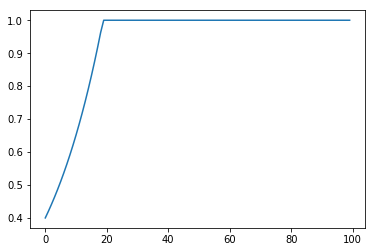

In [39]:
betas = [get_beta(i) for i in range(100)]
plt.plot(betas)

In [40]:
#this is the entirety of prioritized memory class
class PrioritizedMemory:
    def __init__(self, memory_size, alpha = 0.6):
        self.memory_size = memory_size
        self.memory = deque(maxlen=memory_size)
        self.alpha = alpha
        self.priority = deque(maxlen=memory_size)
        self.probs = np.zeros(memory_size)
        
    def add(self, *args):
        max_prior = max(self.priority) if self.memory else 1.
        t = {'state':args[0],'action':args[1],'reward':args[2],'next_state':args[3],'done':args[4]}
        self.memory.append(t)
        #give latest transition max priority for optimistic start
        self.priority.append(max_prior)
        
    def prior_to_prob(self):
        #uniform sampling when alpha is 0
        probs = np.array([i**self.alpha for i in self.priority]) 
        self.probs[range(len(self.priority))] = probs
        self.probs /= np.sum(self.probs)
        
    def sample(self, batch_size, beta = 0.4):
        #calculate prob every time we will sample
        self.prior_to_prob()
        idx = np.random.choice(range(self.memory_size), batch_size, replace=False, p=self.probs)
        ts = [self.memory[i] for i in idx]
        
        #stitch tuple
        states = tf.cast(np.vstack([t['state'] for t in ts]),dtype=tf.float32)
        actions = tf.cast(np.vstack([t['action'] for t in ts]),dtype=tf.int32)
        rewards = tf.cast(np.vstack([t['reward'] for t in ts]),dtype=tf.float32)
        next_states = tf.cast(np.vstack([t['next_state'] for t in ts]),dtype=tf.float32)
        dones = tf.cast(np.vstack([t['done'] for t in ts]),dtype=tf.float32)
        
        #importance sampling weights
        #higher beta, higher compensation for prioritized sampling
        sampling_weights = (len(self.memory)*self.probs[idx])**(-beta)
        #normalize by max weight to always scale down
        sampling_weights = sampling_weights / np.max(sampling_weights) 
        sampling_weights = tf.cast(sampling_weights, dtype=tf.float32)
        return(states,actions,rewards,next_states,dones,idx,sampling_weights)
    
    def update_priority(self, idx, losses):
        for i, l in zip(idx, losses): 
            self.priority[i] = l.numpy().squeeze()
        
    def __len__(self):
        return len(self.memory)

**Coding Assignment** Create `get_beta` and `wis_loss` methods in agent and modify `learn` to accommodate for prioritized memory.

In [43]:
class DQNAgent:
    def __init__(self, state_size, action_size, replay_memory,
        lr=1e-3, bs = 64, clip=1., hidden_sizes = [256,256],
        gamma=0.99, tau= 1e-3, update_interval = 5, update_times = 1,
        Architecture=DenseNetwork, double=True):
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_sizes = hidden_sizes
        self.lr = lr
        self.bs = bs
        self.gamma = gamma
        self.update_interval = update_interval
        self.update_times = update_times
        self.tau = tau
        self.losses = []
        self.clip = clip
        self.Architecture = Architecture
        self.double = double

        #networks
        self.network_local = Architecture(output_size=self.action_size, hidden_sizes = self.hidden_sizes, 
            input_size=state_size)
        self.network_local.build(input_shape=(None,self.state_size))
        self.network_target = Architecture(output_size=self.action_size,hidden_sizes=self.hidden_sizes,
            input_size=state_size)
        self.network_target.build(input_shape=(None,self.state_size))
        #make the target network exactly same as the local network
        self.network_target.set_weights(self.network_local.get_weights())
        
        #optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, clipvalue=self.clip)
        
        # replay memory
        self.memory = replay_memory
        # count time steps and episodes
        self.t_step = 0
        self.episodes = 0
    
    def step(self, state, action, reward, next_state, done):
        #add transition to replay memory
        self.memory.add(state, action, reward, next_state, done, #for all others
            self.episodes, self.t_step) #for nstep memory

        #increment episodes if done
        if done: 
            self.t_step = 0
            self.episodes+=1
        
        #update target network
        self.soft_update()
        #self.hard_update()
        
        # learn every self.t_step
        self.t_step += 1
        if self.t_step % self.update_interval == 0:
            if len(self.memory) > self.bs:
                for _ in range(self.update_times):
                    if isinstance(self.memory,PrioritizedMemory):
                        transitions = self.memory.sample(self.bs, self.get_beta(self.episodes))
                    else:
                        transitions = self.memory.sample(self.bs)
                    loss = self.learn(transitions)
                    self.losses.append(loss)

    def act(self, state):
        eps = self.get_eps(self.episodes)
        action_values = self.network_local(tf.cast(state[None,:],dtype=tf.float32))
        #epsilon greedy exploration
        if random.random() > eps:
            return np.argmax(action_values.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    #we use tf.function decorator for training process to switch from eager to static graph
    #NOT compatible with PrioritizedMemory yet
    #with decorator
    #1.64 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    #without decorator
    #2.93 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
#     @tf.function
    def learn(self, transitions):
        '''
        Fill in the codes
        '''
        if isinstance(self.memory, PrioritizedMemory):
            #unpack (states, actions, rewards, next_states, dones, idx, sampling_weights) from transitions
        else:
            states, actions, rewards, next_states, dones = transitions

        if self.double:
            max_actions_next = tf.cast(tf.argmax(self.network_local(next_states),1), dtype=tf.int32)
            seq = tf.range(0, actions.shape[0])
            max_action_idxs = tf.transpose(tf.stack([seq, max_actions_next]))
            q_targets_next = tf.gather_nd(self.network_target(next_states), max_action_idxs)[:,tf.newaxis]
        else:
            q_targets_next = tf.reduce_max(self.network_target(next_states),1)[:,tf.newaxis]
            
        #bellman
        q_targets = rewards + (self.gamma * q_targets_next) * (1 - dones)
        q_targets = q_targets[:,0] #flatten q_targets

        with tf.GradientTape() as tape:
            #get predictions of all actions
            preds = self.network_local(states)
            
            #get index of actions used to calculate q_expected
            actions = actions[:,0] #flatten actions
            seq = tf.range(0, actions.shape[0])
            action_idxs = tf.transpose(tf.stack([seq, actions]))

            #get q values only at specific action indice
            #tensorflow has this weird way to gather where you need to put index as
            #[[0, action_idx1],[1, action_idx2],...,[n, action_idxn]]
            q_expected = tf.gather_nd(preds, action_idxs)
            
            '''
            Fill in the codes
            '''
            #calculate loss
            if isinstance(self.memory, PrioritizedMemory):
                #calculate wis_loss
            else:
                loss = self.vanilla_loss(q_targets, q_expected)
            
            #get gradients
            gradients = tape.gradient(loss, self.network_local.trainable_weights)
        
        #apply gradients
        self.optimizer.apply_gradients(zip(gradients,self.network_local.trainable_weights))
        
        return loss

    def vanilla_loss(self, q_targets, q_expected):
        return tf.keras.losses.mse(q_targets, q_expected)

    def hard_update(self):
        if self.t_step % 1/self.tau==0:
            self.network_target.set_weights(self.network_local.get_weights())

    def soft_update(self):
        weights_local = np.array(self.network_local.get_weights())
        weights_target = np.array(self.network_target.get_weights())
        self.network_target.set_weights(self.tau * weights_local + (1 - self.tau) * weights_target)
        
    def get_eps(self, i, eps_start = 1., eps_end = 0.001, eps_decay = 0.9):
        eps = max(eps_start * (eps_decay ** i), eps_end)
        return(eps)
    
    '''
    Fill in the codes
    '''
    def wis_loss(self, q_targets, q_expected, idx, sampling_weights, small_e=1e-5):
        pass
    
    def get_beta(self, i, beta_start = 0.4, beta_end = 1, beta_growth = 1.2):
        pass

In [44]:
env = gym.make('CartPole-v1')
mem = PrioritizedMemory(int(1e5)) 
a = DQNAgent(state_size = env.reset().shape[0], hidden_sizes = [256,256],
             action_size = env.action_space.n, replay_memory = mem,
             Architecture = DuelingNetwork) 
scores, moving_scores, losses, action_df, weight_df = run_agent(env,a)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


W0925 10:58:17.345214 140080772941568 deprecation.py:323] From /home/charin/anaconda3/envs/drlnd/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Episdoe 99 Moving Average: 13.191919191919192
Episdoe 199 Moving Average: 10.89
Episdoe 299 Moving Average: 81.31
Solved at Play 305: 0:03:26.139812 Moving average: 101.56


## N-Step Bootstrapping

**Conceptual Assignment** How do Monte Carlo methods estimate the action/value function? What is the difference between that and of temporal difference methods like Q-learning?

N-step bootstrapping is a very simple concept, so simple that in fact the Rainbow paper did not cite any paper for this but [Introduction to Reinforcement Learning](http://incompleteideas.net/book/bookdraft2017nov5.pdf) book from Page 115 on instead:
* Monte Carlo
$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^T-t-1 R_{terminal}$$
* TD (1-step bootstrapping)
$$G_t = R_{t+1} + \gamma V_t(S_{t+1})$$
* 2-step bootstrapping
$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 V_t(S_{t+2})$$
* N-step bootstrapping
$$G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^{n-1}R_{t+n} + \gamma^n V_{t+n-1}(S_{t+n})$$


![nstep.png](https://i.postimg.cc/JzsjZKZW/nstep.png)

**Conceptual Assignment** What is the bias-variance tradeoff between Monte Carlo and temporal difference methods?

**Coding Assigment** Create a helper function that generates a discounted return based on a list of returns and discount factor `gamma`.

In [46]:
def discounted_returns(returns, gamma = 0.5):
    '''
    Fill in the codes
    '''
    pass

In [48]:
discounted_returns([1,1,1,1,1],gamma=0.5)

1.9375

**[Hard] Coding Assignment** Create an N-step memory.

In [49]:
'''
Fill in the codes
'''

You will need to modify `q_targets` in the agent also:

In [50]:
# if isinstance(self.memory, NStepMemory):
#     #these are not real rewards but discounted returns and we use Q for the n-th step
#     q_targets = rewards + (self.gamma**self.memory.n * q_targets_next) * (1 - dones)
# else:
#     q_targets = rewards + (self.gamma * q_targets_next) * (1 - dones)

## [Noisy Exploration](https://arxiv.org/pdf/1706.10295.pdf)

**Conceptual Assignment** How have we handle explore-vs-exploit dilemma so far? Is there a better way?

Noisy linear layer involves adding factorized Gaussian noise to the weights and biases defined as follows:

$$W = \mu_W + \sigma_W * \epsilon^W_{out,in}$$
$$b = \mu_b + \sigma_b * \epsilon^W_{out,in}$$
$$y = xW^T + b$$

For factorized Gaussian noise, in order to minize computations, we use only two sets of randomized epsilons:

$$\epsilon^W_{out,in} = f(\epsilon_{in})f(\epsilon_{out})$$
$$\epsilon^b_{out} = f(\epsilon_{out})$$

where $f(x)= sign(x)\sqrt{|x|}$ and $in$ and $out$ are number of input and output features.

The initializations are as follows:

* $\mu_W$ and $\mu_b$ from independent uniform distribution $[\frac{-1}{\sqrt{in}},\frac{+1}{\sqrt{in}}]$
* $\sigma_W$ and $\sigma_W$ are initialized to $\frac{sigma_0}{\sqrt{in}}$

$\sigma_0$ is proposed to be 0.5 in the paper but is a tunable hyperparameter (the larger it is the higher noise).

**Coding Assigment** Create a `NoisyDense` layer and incorporate it into your `DenseNetwork`, call it maybe `NoisyDenseNetwork`.

In [61]:
'''
Fill in the codes
'''
class NoisyDense(layers.Layer):
    def __init__(self, output_size, input_size, activation=None):
        super(NoisyDense, self).__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.activation = activation

        #initiate w_mu, b_mu

        #initiate w_sigma, b_sigma

        self.reset_noise()

    def reset_noise(self):
        #reset factorised noise
        pass

    def factorize_noise(self, size):
        #get factorised noise
        pass
        
    def call(self, x, training=True):
        pass

In [62]:
class NoisyDenseNetwork(models.Model):
    def __init__(self, output_size, hidden_sizes, input_size, **args):
        super(NoisyDenseNetwork, self).__init__()
        # self.body = [NoisyDense(hidden_sizes[0], input_size, tf.nn.relu)]
        # for i in range(1, len(hidden_sizes)):
        #     self.body.append(NoisyDense(hidden_sizes[i],hidden_sizes[i-1], tf.nn.relu))
        self.body = [layers.Dense(i, activation='relu') for i in hidden_sizes]
        self.head = NoisyDense(output_size, hidden_sizes[-1])
        self.reset_noise()
    def call(self, x, training=True):
        for l in self.body: x = l(x) 
        return self.head(x, training)
    def reset_noise(self):
        # for l in self.body: l.reset_noise()
        self.head.reset_noise()

In [63]:
class DQNAgent:
    def __init__(self, state_size, action_size, replay_memory,
        lr=1e-3, bs = 64, clip=1., hidden_sizes = [256,256],
        gamma=0.99, tau= 1e-3, update_interval = 5, update_times = 1,
        Architecture=DenseNetwork, double=True):
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_sizes = hidden_sizes
        self.lr = lr
        self.bs = bs
        self.gamma = gamma
        self.update_interval = update_interval
        self.update_times = update_times
        self.tau = tau
        self.losses = []
        self.clip = clip
        self.Architecture = Architecture
        self.double = double

        #networks
        self.network_local = Architecture(output_size=self.action_size, hidden_sizes = self.hidden_sizes, 
            input_size=state_size)
        self.network_local.build(input_shape=(None,self.state_size))
        self.network_target = Architecture(output_size=self.action_size,hidden_sizes=self.hidden_sizes,
            input_size=state_size)
        self.network_target.build(input_shape=(None,self.state_size))
        #make the target network exactly same as the local network
        self.network_target.set_weights(self.network_local.get_weights())
        
        #optimizer
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, clipvalue=self.clip)
        
        # replay memory
        self.memory = replay_memory
        # count time steps and episodes
        self.t_step = 0
        self.episodes = 0
    
    def step(self, state, action, reward, next_state, done):
        #add transition to replay memory
        self.memory.add(state, action, reward, next_state, done, #for all others
            self.episodes, self.t_step) #for nstep memory

        #increment episodes if done
        if done: 
            self.t_step = 0
            self.episodes+=1
        
        #update target network
        self.soft_update()
        #self.hard_update()
        
        # learn every self.t_step
        self.t_step += 1
        if self.t_step % self.update_interval == 0:
            if len(self.memory) > self.bs:
                for _ in range(self.update_times):
                    if isinstance(self.memory,PrioritizedMemory):
                        transitions = self.memory.sample(self.bs, self.get_beta(self.episodes))
                    else:
                        transitions = self.memory.sample(self.bs)
                    loss = self.learn(transitions)
                    self.losses.append(loss)

    def act(self, state):
        eps = self.get_eps(self.episodes)
        action_values = self.network_local(tf.cast(state[None,:],dtype=tf.float32))
        '''
        Fill in the codes to perform noisey exploration instead of epsilon-greedy
        '''
        
        #epsilon greedy exploration
        if random.random() > eps:
            return np.argmax(action_values.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    #we use tf.function decorator for training process to switch from eager to static graph
    #NOT compatible with PrioritizedMemory yet
    #with decorator
    #1.64 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    #without decorator
    #2.93 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
#     @tf.function
    def learn(self, transitions):
        if isinstance(self.memory, PrioritizedMemory):
            states, actions, rewards, next_states, dones, idx, sampling_weights = transitions
        else:
            states, actions, rewards, next_states, dones = transitions

        if self.double:
            max_actions_next = tf.cast(tf.argmax(self.network_local(next_states),1), dtype=tf.int32)
            seq = tf.range(0, actions.shape[0])
            max_action_idxs = tf.transpose(tf.stack([seq, max_actions_next]))
            q_targets_next = tf.gather_nd(self.network_target(next_states), max_action_idxs)[:,tf.newaxis]
        else:
            q_targets_next = tf.reduce_max(self.network_target(next_states),1)[:,tf.newaxis]
            
        #bellman
        if isinstance(self.memory, NStepMemory):
            #these are not real rewards but discounted returns and we use Q for the n-th step
            q_targets = rewards + (self.gamma**self.memory.n * q_targets_next) * (1 - dones)
        else:
            q_targets = rewards + (self.gamma * q_targets_next) * (1 - dones)
        q_targets = q_targets[:,0] #flatten q_targets

        with tf.GradientTape() as tape:
            #get predictions of all actions
            preds = self.network_local(states)
            
            #get index of actions used to calculate q_expected
            actions = actions[:,0] #flatten actions
            seq = tf.range(0, actions.shape[0])
            action_idxs = tf.transpose(tf.stack([seq, actions]))

            #get q values only at specific action indice
            #tensorflow has this weird way to gather where you need to put index as
            #[[0, action_idx1],[1, action_idx2],...,[n, action_idxn]]
            q_expected = tf.gather_nd(preds, action_idxs)
            
            #calculate loss
            if isinstance(self.memory, PrioritizedMemory):
                loss = self.wis_loss(q_targets, q_expected, idx, sampling_weights)
            else:
                loss = self.vanilla_loss(q_targets, q_expected)
            
            #get gradients
            gradients = tape.gradient(loss, self.network_local.trainable_weights)
        
        #apply gradients
        self.optimizer.apply_gradients(zip(gradients,self.network_local.trainable_weights))

        '''
        Fill in the codes to reset noise
        '''

        return loss

    def vanilla_loss(self, q_targets, q_expected):
        return tf.keras.losses.mse(q_targets, q_expected)

    def hard_update(self):
        if self.t_step % 1/self.tau==0:
            self.network_target.set_weights(self.network_local.get_weights())

    def soft_update(self):
        weights_local = np.array(self.network_local.get_weights())
        weights_target = np.array(self.network_target.get_weights())
        self.network_target.set_weights(self.tau * weights_local + (1 - self.tau) * weights_target)
        
    def get_eps(self, i, eps_start = 1., eps_end = 0.001, eps_decay = 0.9):
        eps = max(eps_start * (eps_decay ** i), eps_end)
        return(eps)
    
    def wis_loss(self, q_targets, q_expected, idx, sampling_weights, small_e=1e-5):
        losses = tf.pow(q_expected-q_targets, 2) * sampling_weights
        self.memory.update_priority(idx,losses+small_e)
        loss = tf.reduce_mean(losses)
        return loss
    
    def get_beta(self, i, beta_start = 0.4, beta_end = 1, beta_growth = 1.2):
        beta = min(beta_start * (beta_growth ** i), beta_end)
        return(beta)

In [64]:
env = gym.make('CartPole-v1')
mem = PrioritizedMemory(int(1e5)) 
a = DQNAgent(state_size = env.reset().shape[0], hidden_sizes = [256,256],
             action_size = env.action_space.n, replay_memory = mem,
             Architecture = NoisyDenseNetwork) 
scores, moving_scores, losses, action_df, weight_df = run_agent(env,a)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Episdoe 99 Moving Average: 9.797979797979798
Episdoe 199 Moving Average: 9.44
Episdoe 299 Moving Average: 9.38
Episdoe 399 Moving Average: 9.43
Episdoe 499 Moving Average: 9.28
Episdoe 599 Moving Average: 9.65
Episdoe 699 Moving Average: 40.74
Solved at Play 728: 0:04:08.438498 Moving average: 100.16


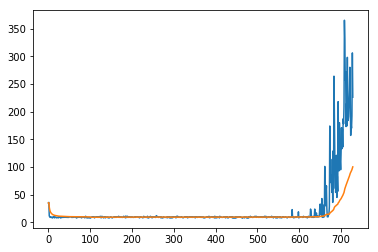

In [65]:
plt.plot(scores)
plt.plot(moving_scores)

## Conclusion

Our (almost) Rainbow agent is not a state-of-the-art in deep reinforcement learning but it allows us to understand and implement some important concepts researchers are using to implement state-of-the-art algorithms such as:
* Decoupling training samples to over/underfitting
* Decoupling esitmators to avoid over/underestimation
* Efficiently reusing past transitions
* Estimating advantage to emphasizes impactful actions
* Selecting impactful training samples
* Bias-variance tradeoff in estimating discounted returns
* Explore-vs-exploit dilemma

![dqn-fixed.png](https://i.postimg.cc/dt4rqZd7/dqn-fixed.png)


## Homework

Fill in the codes in `dqn_trading.ipynb`.

## References

* Fortunato, M.; Azar, M. G.; Piot, B.; Menick, J.; Osband, I.; Graves, A.; Mnih, V.; Munos, R.; Hassabis, D.; Pietquin, O.; Blundell, C.; and Legg, S. 2017. Noisy networks for exploration. CoRR abs/1706.10295.
* Kurenkov, A. (2018). Reinforcement learning's foundational flaw. Retrieved from https://thegradient.pub/why-rl-is-flawed/
* Mnih, V.; Kavukcuoglu, K.; Silver, D.; Graves, A.; Antonoglou, I.; Wierstra, D.; and Riedmiller, M. A. 2013.Playing atari with deep reinforcement learning. CoRR
abs/1312.5602.
* Russell, S. & Norvig, S. (2009). Artificial Intelligence: A Modern Approach. Third Edition. Prentice Hall.
* Sutton, R. S., and Barto, A. G. 1998. Reinforcement Learning: An Introduction. The MIT press, Cambridge MA.
* van Hasselt, H.; Guez, A.; and Silver, D. 2016. Deep reinforcement learning with double Q-learning. In Proc. of AAAI, 2094–2100.
* Wang, Z.; Schaul, T.; Hessel, M.; van Hasselt, H.; Lanctot, M.; and de Freitas, N. 2016. Dueling network architectures for deep reinforcement learning. In Proceedings of The 33rd International Conference on Machine Learning, 1995–2003.